In [1]:
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.utils import get_file

try:
    path = tf.keras.utils.get_file('kddcup.data_10_percent.gz', origin=
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's 
# (rows with missing values)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
# display 5 rows
display(df[0:5])

C:\Users\RyanJoung\.keras\datasets\kddcup.data_10_percent.gz
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
2,0,tcp,...,0.0,normal.
3,0,tcp,...,0.0,normal.
4,0,tcp,...,0.0,normal.


## Analyzing a Dataset
Before we preprocess the KDD99 dataset let's have a look at the individual columns and distributions. You can use the following script to give a high-level overview of how a dataset appears.

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [3]:

# Analyze KDD-99
analyze(df)


494021 rows
** duration:2495 (0%)
** protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,whois:0.02%,sql_net:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,mtp:0.02%,vmnet:0.02%,uucp_path:0.02%,uucp:0.02%,klogin:0.02%,bgp:0.02%,ssh:0.02%,supdup:0.02%,nnsp:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,exec:0.02%,http_443:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
** flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S

## Encode the feature vector
We use the same two functions provided earlier to preprocess the data. The first encodes Z-Scores, and the second creates dummy variables from categorical columns.

In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [5]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net


# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [6]:
df.groupby('outcome')['outcome'].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

## Train the Neural Network

In [7]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
11579/11579 - 7s - loss: 0.1071 - val_loss: 0.0463
Epoch 2/1000
11579/11579 - 7s - loss: 0.0407 - val_loss: 0.0364
Epoch 3/1000
11579/11579 - 6s - loss: 0.0347 - val_loss: 0.0309
Epoch 4/1000
11579/11579 - 7s - loss: 0.0320 - val_loss: 0.0282
Epoch 5/1000
11579/11579 - 6s - loss: 0.0292 - val_loss: 0.0292
Epoch 6/1000
11579/11579 - 7s - loss: 0.0301 - val_loss: 0.0260
Epoch 7/1000
11579/11579 - 6s - loss: 0.0280 - val_loss: 0.0241
Epoch 8/1000
11579/11579 - 6s - loss: 0.0277 - val_loss: 0.0248
Epoch 9/1000
11579/11579 - 7s - loss: 0.0271 - val_loss: 0.0250
Epoch 10/1000
11579/11579 - 6s - loss: 0.0262 - val_loss: 0.0228
Epoch 11/1000
11579/11579 - 7s - loss: 0.0251 - val_loss: 0.0226
Epoch 12/1000
11579/11579 - 7s - loss: 0.0274 - val_loss: 0.0235
Epoch 13/1000
11579/11579 - 7s - loss: 0.0253 - val_loss: 0.0226
Epoch 14/1000
11579/11579 - 7s - loss: 0.0258 - val_loss: 0.0237
Epoch 15/1000
Restoring model weights from the end of the best epoch.
11579/11579 - 8s - loss: 0.02

In [56]:
# Measure accuracy
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_test, y_pred)
print("Validation score: {}".format(score))

AxisError: axis 1 is out of bounds for array of dimension 1

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    
# Estimation: Confusion Matrix & classification-report 
# _confusion_matrix = confusion_matrix(y_test, y_pred)
arr_outcomes = list(outcomes)
arr_outcomes2 = (arr_outcomes[:19] + arr_outcomes[21:23])
_classification_report = classification_report(y_test, y_pred, target_names=arr_outcomes2, output_dict=False)
_classification_report_dict = classification_report(y_test, y_pred, target_names=arr_outcomes2, output_dict=True)

# print(_confusion_matrix)
print(_classification_report)

C:\Users\RyanJoung\.conda\envs\mybook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RyanJoung\.conda\envs\mybook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RyanJoung\.conda\envs\mybook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RyanJou

                  precision    recall  f1-score   support

           back.       0.64      1.00      0.78       541
buffer_overflow.       0.00      0.00      0.00        11
      ftp_write.       0.00      0.00      0.00         1
   guess_passwd.       0.00      0.00      0.00        10
           imap.       0.00      0.00      0.00         3
        ipsweep.       0.90      0.97      0.93       324
           land.       0.00      0.00      0.00         5
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     26708
           nmap.       0.00      0.00      0.00        52
         normal.       1.00      1.00      1.00     24267
           perl.       0.00      0.00      0.00         2
            phf.       0.00      0.00      0.00        46
            pod.       0.96      0.98      0.97       287
      portsweep.       0.00      0.00      0.00         1
        rootk

C:\Users\RyanJoung\.conda\envs\mybook\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
def roc_auc_score_multiclass(y_test, y_pred, average = "macro"):
    """roc_auc_score_multiclass function evaluate the multiclass output as a ROC AUC score.
    
    :param y_test: test label    
    :param y_pred: test label    
    :param average: "macro" or Label encoder    
    :return: _confusion_matrix, _classification_report, _auc_dict, _classification_report_dict
    """
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(y_test)
    roc_auc_dict = {}
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_y_test = [0 if x in other_class else 1 for x in y_test]
        new_y_pred = [0 if x in other_class else 1 for x in y_pred]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_y_test, new_y_pred, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict


-----Confusion Matrix-----

[[  540     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0]
 [    4     0     0     0     0     1     0     0     0     0     0     1
      0     0     0     0     5     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     1     0     0     0     0]
 [    1     0     0     0     0     8     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0]
 [    1     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     2     0     0]
 [    0     0     0     0     0   314     0     0     0     0     0     2
      0     0     0     0     8     0     0     0     0]
 [    0     0     0     0     0     5     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     1     0     0     

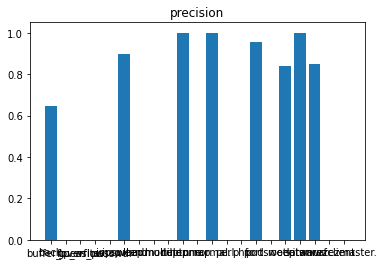

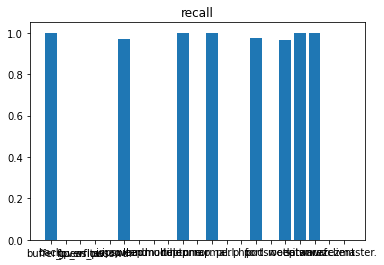

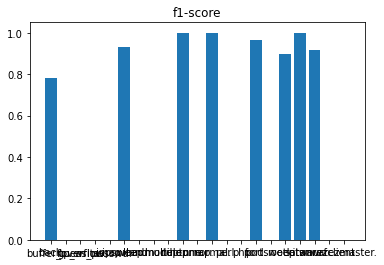

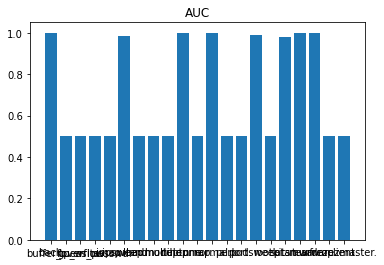

In [64]:
from matplotlib import pyplot
# For Multiclass AUC
_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
_auc_dict = dict((arr_outcomes[key], value) for (key, value) in _auc_dict.items())

print('\n-----Confusion Matrix-----\n')
print(_confusion_matrix)
print('\n-----Classification Report-----\n')
print(_classification_report)
print('\n-----AUC Dictionary-----\n')
print(str(_auc_dict))

metrix = ['precision', 'recall', 'f1-score']
#     metrix = ['precision', 'recall', 'f1-score', 'support']
xKeys = arr_outcomes2
for met in metrix:
    xValues = []
    for target_name in arr_outcomes2:
        xValues += [_classification_report_dict[target_name][met]]

    pyplot.title(met)
    pyplot.bar(range(len(xValues)), list(xValues), align='center')
    pyplot.xticks(range(len(xKeys)), list(xKeys))
    pyplot.show()

pyplot.title('AUC')
pyplot.bar(range(len(_auc_dict)), list(_auc_dict.values()), align='center')
pyplot.xticks(range(len(_auc_dict)), list(_auc_dict.keys()))
pyplot.show()